# COVID-19 

This is my new version of analyses of COVID-19.  

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from pathlib import Path
import numpy as np
import pandas as pd
import datetime
import time

# Canada

In [2]:
from src.phac import PHAC


can = PHAC()
as_of = "2020-07-21"

## Total Cases

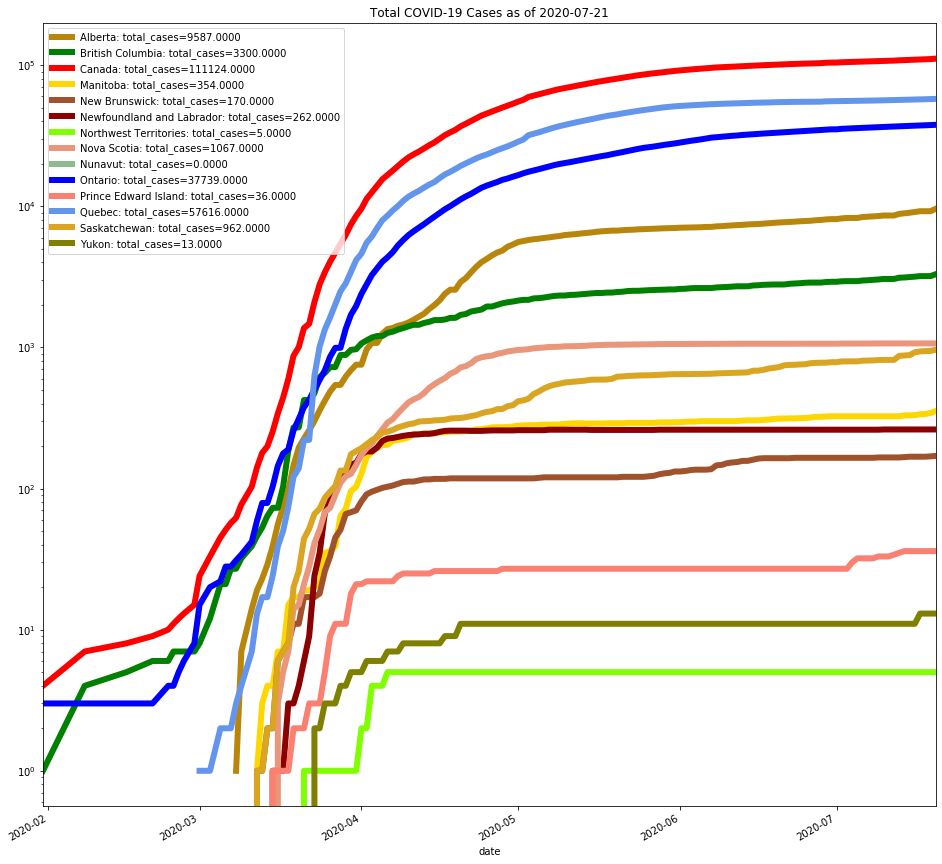

In [3]:
can_tc_fig = can.plot_var("total_cases", *can.provinces,
    figsize=(16,16),
    log_scale=True,
    colours=can.prov_colours,
    #date_start="2020-03-01",
    lw=6,
    title=f"Total COVID-19 Cases as of {as_of}"  
)


plt.show()

In [4]:
var_pivot = can.var_by_location("total_cases", *can.provinces)
var_pivot[-7:][can.provinces]

location,Canada,Newfoundland and Labrador,Prince Edward Island,Nova Scotia,New Brunswick,Quebec,Ontario,Manitoba,Saskatchewan,Alberta,British Columbia,Yukon,Northwest Territories,Nunavut
date,,,,,,,,,,,,,,
2020-07-14,108486.0,262.0,36.0,1066.0,167.0,56730.0,36950.0,330.0,876.0,8912.0,3128.0,11.0,5.0,0.0
2020-07-15,108827.0,262.0,36.0,1067.0,168.0,56859.0,37052.0,330.0,881.0,8994.0,3149.0,11.0,5.0,0.0
2020-07-16,109264.0,262.0,36.0,1067.0,168.0,57001.0,37163.0,331.0,923.0,9114.0,3170.0,11.0,5.0,0.0
2020-07-17,109669.0,262.0,36.0,1067.0,168.0,57142.0,37274.0,336.0,936.0,9219.0,3198.0,13.0,5.0,0.0
2020-07-18,109999.0,262.0,36.0,1067.0,168.0,57300.0,37440.0,337.0,941.0,9219.0,3198.0,13.0,5.0,0.0
2020-07-19,110338.0,262.0,36.0,1067.0,169.0,57466.0,37604.0,343.0,943.0,9219.0,3198.0,13.0,5.0,0.0
2020-07-20,111124.0,262.0,36.0,1067.0,170.0,57616.0,37739.0,354.0,962.0,9587.0,3300.0,13.0,5.0,0.0


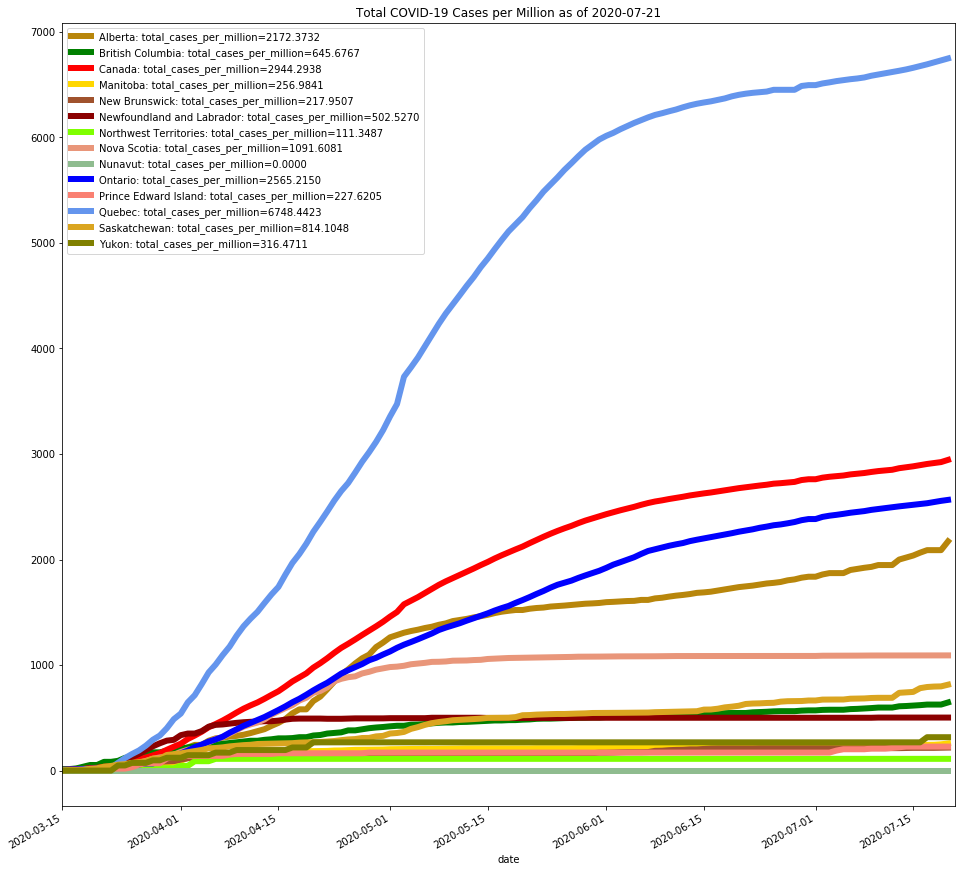

In [5]:
can_tcpm_fig = can.plot_var("total_cases_per_million", *can.provinces,
    figsize=(16,16),
    #log_scale=True,
    colours=can.prov_colours,
    date_start="2020-03-15",
    date_end=as_of,
    lw=6,
    title=f"Total COVID-19 Cases per Million as of {as_of}"  
)


plt.show()

## New cases

In [6]:
can.prov_colours

{'Canada': 'r',
 'Newfoundland and Labrador': 'darkred',
 'Prince Edward Island': 'salmon',
 'Nova Scotia': 'darksalmon',
 'New Brunswick': 'sienna',
 'Quebec': 'cornflowerblue',
 'Ontario': 'b',
 'Manitoba': 'gold',
 'Saskatchewan': 'goldenrod',
 'Alberta': 'darkgoldenrod',
 'British Columbia': 'g',
 'Yukon': 'olive',
 'Northwest Territories': 'chartreuse',
 'Nunavut': 'darkseagreen'}

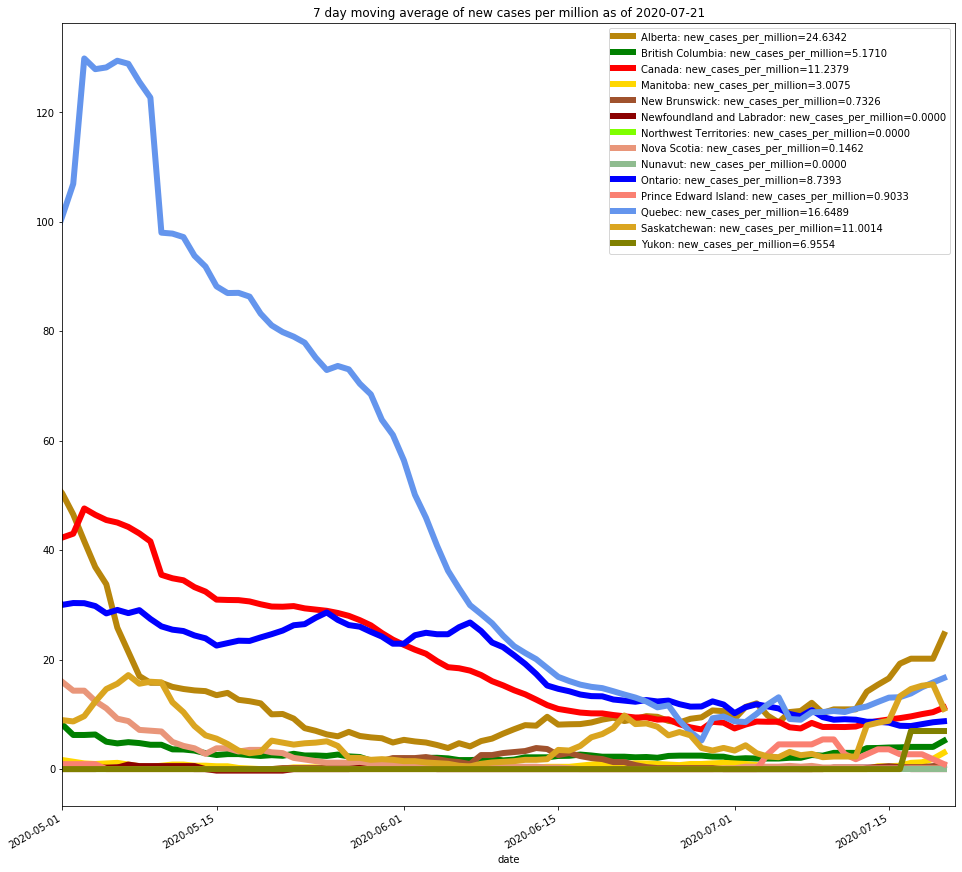

In [7]:
ma_win = 7
can_nc_fig = can.plot_var("new_cases_per_million", *can.provinces, ma_window=ma_win,
    figsize=(16,16),
    #log_scale=True,
    colours=can.prov_colours,
    date_start="2020-05-01",
    date_end=as_of,
    lw=6,
    title=f"{ma_win} day moving average of new cases per million as of {as_of}"  
)

savefile = f"{as_of}_COVID-19_NCperMil_{ma_win}_days.png"
plt.savefig(Path.home().joinpath("Downloads/" + savefile),
           format="png")

plt.show()

In [8]:
ma_win = 7
can_ptg = can.cum_pos_test_growth_rate(ma_win, *can.provinces)
can_ptg

/Users/bill/IdeaProjects/covid-19/src/dataset.py:189: RuntimeWarning: invalid value encountered in power
  growth = lambda x: np.power(x, 1 / window)


location,Alberta,British Columbia,Canada,Manitoba,New Brunswick,Newfoundland and Labrador,Northwest Territories,Nova Scotia,Nunavut,Ontario,Prince Edward Island,Quebec,Saskatchewan,Yukon
date,,,,,,,,,,,,,,
2020-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-16,-0.002792,-0.004006,-0.010138,-0.007460,-0.004994,-0.011035,-0.007638,-0.006210,NaN,-0.012119,-0.012751,-0.009581,0.006837,-0.005940
2020-07-17,-0.001867,-0.004020,-0.010101,-0.004838,-0.005157,-0.011883,-0.007245,-0.006189,NaN,-0.012223,-0.014347,-0.009960,0.007937,0.015417
2020-07-18,-0.001867,-0.004240,-0.009907,-0.004388,-0.005124,-0.011634,-0.007245,-0.005981,NaN,-0.011732,-0.011875,-0.010288,0.008008,0.015417


In [9]:
can_nc = can.var_by_location("new_cases", *can.provinces)
can_nc[-7:][can.provinces]

location,Canada,Newfoundland and Labrador,Prince Edward Island,Nova Scotia,New Brunswick,Quebec,Ontario,Manitoba,Saskatchewan,Alberta,British Columbia,Yukon,Northwest Territories,Nunavut
date,,,,,,,,,,,,,,
2020-07-14,331.0,0.0,1.0,0.0,1.0,109.0,111.0,5.0,5.0,86.0,13.0,0.0,0.0,0.0
2020-07-15,341.0,0.0,0.0,1.0,1.0,129.0,102.0,0.0,5.0,82.0,21.0,0.0,0.0,0.0
2020-07-16,437.0,0.0,0.0,0.0,0.0,142.0,111.0,1.0,42.0,120.0,21.0,0.0,0.0,0.0
2020-07-17,405.0,0.0,0.0,0.0,0.0,141.0,111.0,5.0,13.0,105.0,28.0,2.0,0.0,0.0
2020-07-18,330.0,0.0,0.0,0.0,0.0,158.0,166.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0
2020-07-19,339.0,0.0,0.0,0.0,1.0,166.0,164.0,6.0,2.0,0.0,0.0,0.0,0.0,0.0
2020-07-20,786.0,0.0,0.0,0.0,1.0,150.0,135.0,11.0,19.0,368.0,102.0,0.0,0.0,0.0


## Tests

In [10]:
ma_win = 14

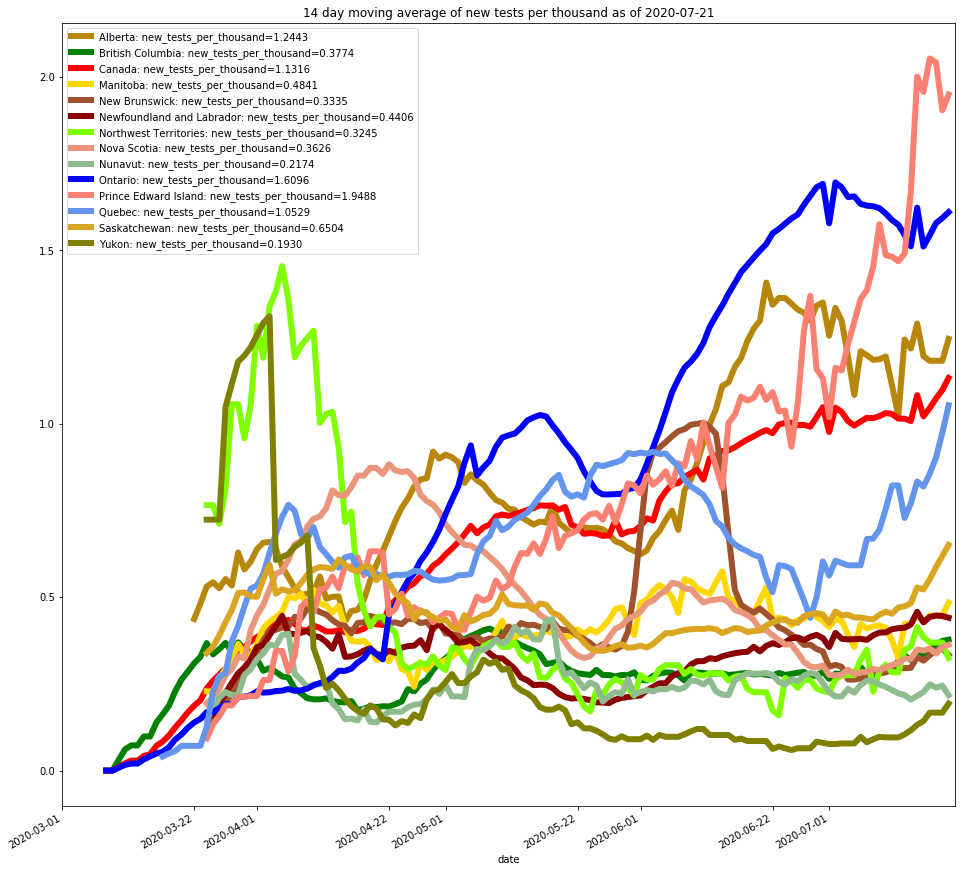

In [11]:

can_nt_fig = can.plot_var("new_tests_per_thousand", *can.provinces, ma_window=ma_win,
    figsize=(16,16),
    #log_scale=True,
    colours=can.prov_colours,
    date_start="2020-03-01",
    date_end=as_of,
    lw=6,
    title=f"{ma_win} day moving average of new tests per thousand as of {as_of}"  
)


plt.show()

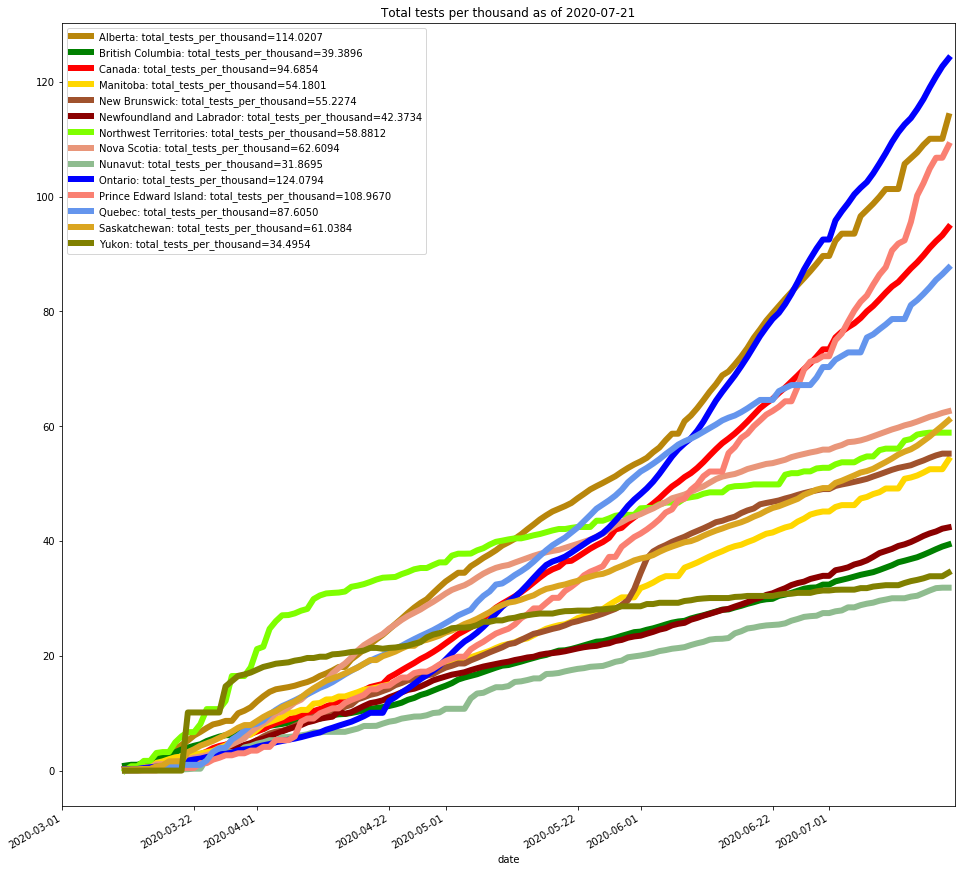

In [12]:
can_ttpt_fig = can.plot_var("total_tests_per_thousand", *can.provinces,
    figsize=(16,16),
    #log_scale=True,
    colours=can.prov_colours,
    date_start="2020-03-01",
    date_end=as_of,
    lw=6,
    title=f"Total tests per thousand as of {as_of}"  
)


plt.show()

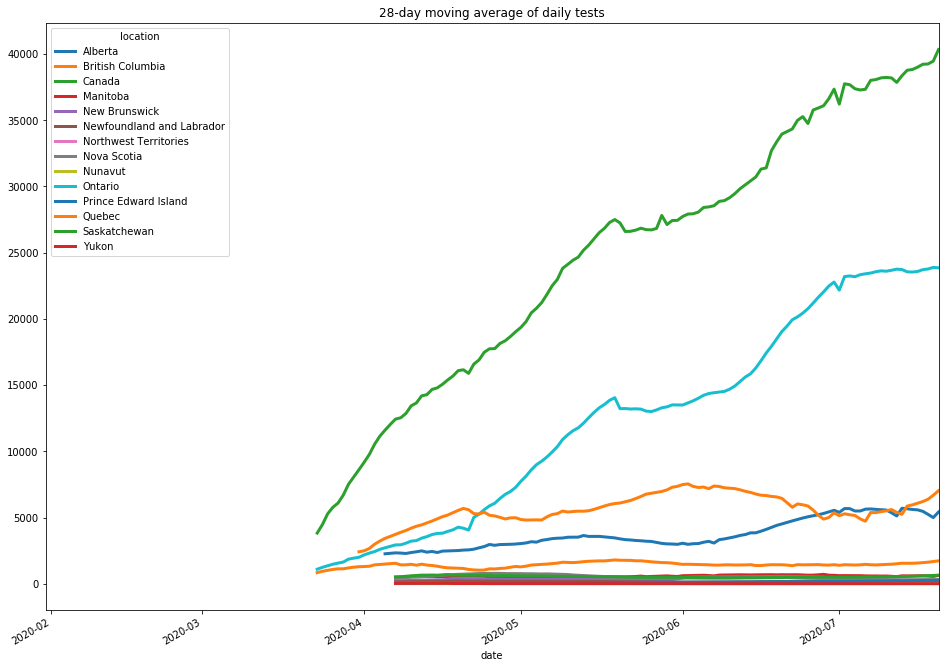

In [13]:
# Plot Daily Tests - Use Average over last ma_win days
ma_win = 28
locations = can.provinces

can_nt = can.var_by_location("new_tests", *locations).rolling(ma_win).mean()

start_date = can_nt.index[0]
end_date = can_nt.index[-1]

plot_properties = dict(
    figsize=(16,12),
    xlim=(start_date, end_date),
    logy=False,
    lw=3,
    #color=[can.prov_colours[loc] for loc in locations],
    title=f"{ma_win}-day moving average of daily tests",
)

fig = can_nt.plot(**plot_properties)

#legend_labels = [f"{loc}: Daily Tests={can_nt.to_dict()[loc][max(can_nt[:end_date].index)]:.4f}"
#                 for loc in sorted(locations)]
#plt.legend(legend_labels)

plt.show()

In [14]:
can.prov_colours

{'Canada': 'r',
 'Newfoundland and Labrador': 'darkred',
 'Prince Edward Island': 'salmon',
 'Nova Scotia': 'darksalmon',
 'New Brunswick': 'sienna',
 'Quebec': 'cornflowerblue',
 'Ontario': 'b',
 'Manitoba': 'gold',
 'Saskatchewan': 'goldenrod',
 'Alberta': 'darkgoldenrod',
 'British Columbia': 'g',
 'Yukon': 'olive',
 'Northwest Territories': 'chartreuse',
 'Nunavut': 'darkseagreen'}

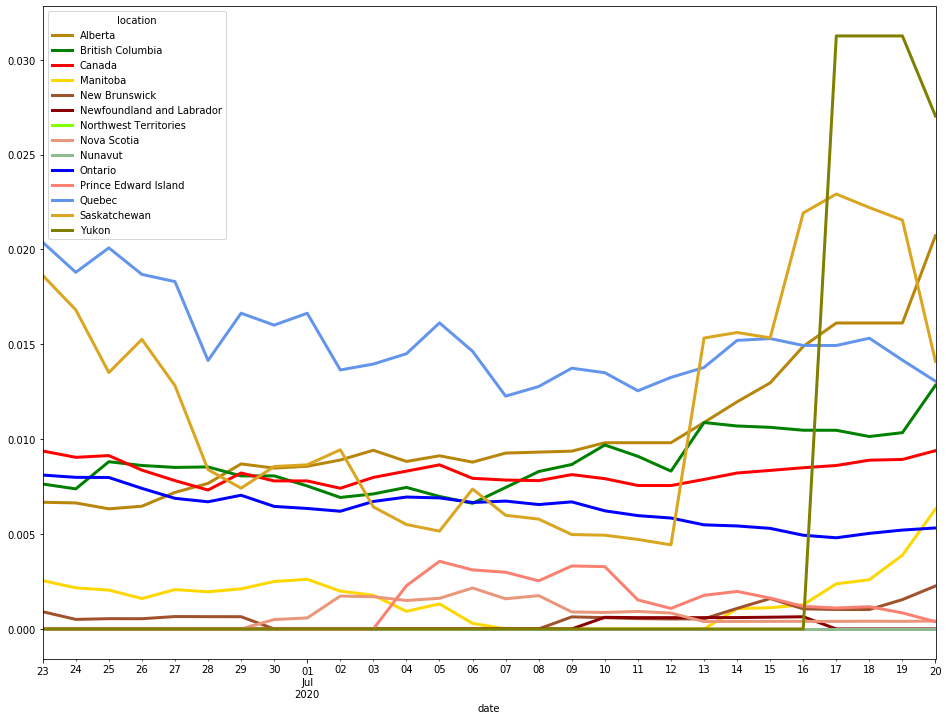

In [15]:
# Plot the positive test rate over the last ma_win days
ma_win = 7
locations = can.provinces


#can_nt_rtot = can.var_by_location("total_tests", *locations).diff(periods=ma_win)
#can_nc_rtot = can.var_by_location("total_cases", *locations).diff(periods=ma_win)
#can_pt = can_nc_rtot / (can_nt_rtot)
can_pt = can.pos_test_rate(ma_win, *locations)

can_pt[-28:].plot(
    figsize=(16,12),
    color=[can.prov_colours[loc] for loc in sorted(locations)],
    lw=3
)


[[0.18753792 0.12065237 0.0897514  0.06130264 0.02238795 0.
  0.         0.0041599  0.         0.05185738 0.00380532 0.1225327
  0.13168177 0.23738608]]
['Alberta', 'British Columbia', 'Canada', 'Manitoba', 'New Brunswick', 'Newfoundland and Labrador', 'Northwest Territories', 'Nova Scotia', 'Nunavut', 'Ontario', 'Prince Edward Island', 'Quebec', 'Saskatchewan', 'Yukon']


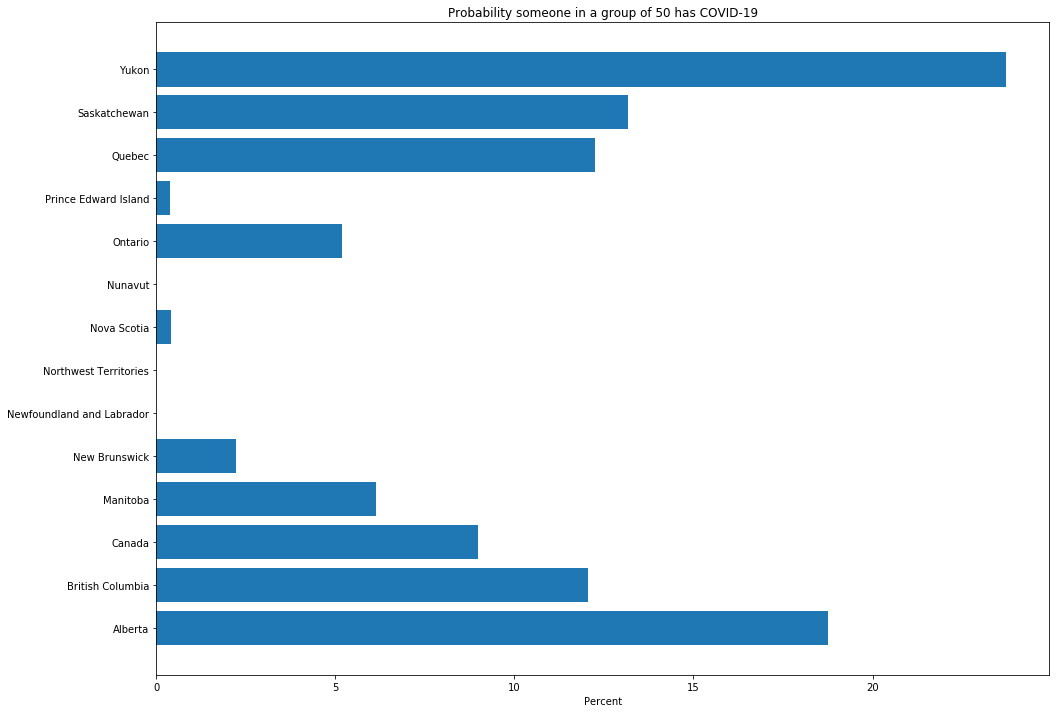

In [16]:
def prob_exposure(group_size, ptr, isolation_compliance=0.8):
    return 1 - np.power(1 - ptr + isolation_compliance * ptr, group_size)

group_size = 50
can_pe = can_pt.apply(lambda ptr: prob_exposure(group_size, ptr))

print(can_pe[-1:].values)
print(list(can_pe.columns))


pe_fig, pe_ax = plt.subplots(figsize=(16,12))

pe_ax.barh(list(can_pe.columns), 100 * can_pe[-1:].values[0])
pe_ax.set_xlabel("Percent")
pe_ax.set_title(f"Probability someone in a group of {group_size} has COVID-19")

savefile = f"{as_of}_COVID-19_ProbExp_{group_size}.png"
plt.savefig(Path.home().joinpath("Downloads/" + savefile),
           format="png")

plt.show()

In [17]:
can.active_confirmed_cases(*can.provinces)[-14:]

location,Alberta,British Columbia,Canada,Manitoba,New Brunswick,Newfoundland and Labrador,Northwest Territories,Nova Scotia,Nunavut,Ontario,Prince Edward Island,Quebec,Saskatchewan,Yukon
date,,,,,,,,,,,,,,
2020-07-07,655.0,155.0,4203.0,11.0,0.0,0.0,0.0,4.0,0.0,2207.0,5.0,1113.0,53.0,0.0
2020-07-08,657.0,159.0,4191.0,10.0,0.0,0.0,0.0,5.0,0.0,2162.0,5.0,1142.0,51.0,0.0
2020-07-09,668.0,159.0,4182.0,9.0,1.0,0.0,0.0,5.0,0.0,2143.0,6.0,1137.0,54.0,0.0
2020-07-10,708.0,175.0,4331.0,7.0,1.0,1.0,0.0,5.0,0.0,2148.0,6.0,1237.0,43.0,0.0
2020-07-11,639.0,175.0,4314.0,3.0,1.0,1.0,0.0,5.0,0.0,2118.0,6.0,1328.0,38.0,0.0
2020-07-12,600.0,175.0,4340.0,3.0,1.0,1.0,0.0,5.0,0.0,2069.0,7.0,1442.0,37.0,0.0
2020-07-13,759.0,211.0,4237.0,1.0,1.0,1.0,0.0,5.0,0.0,1928.0,8.0,1231.0,92.0,0.0
2020-07-14,804.0,212.0,4282.0,5.0,2.0,1.0,0.0,4.0,0.0,1882.0,9.0,1272.0,91.0,0.0
2020-07-15,886.0,233.0,4623.0,5.0,3.0,1.0,0.0,5.0,0.0,1984.0,9.0,1401.0,96.0,0.0


/Users/bill/IdeaProjects/covid-19/src/dataset.py:156: RuntimeWarning: invalid value encountered in power
  growth = lambda x: np.power(x, 1 / window)


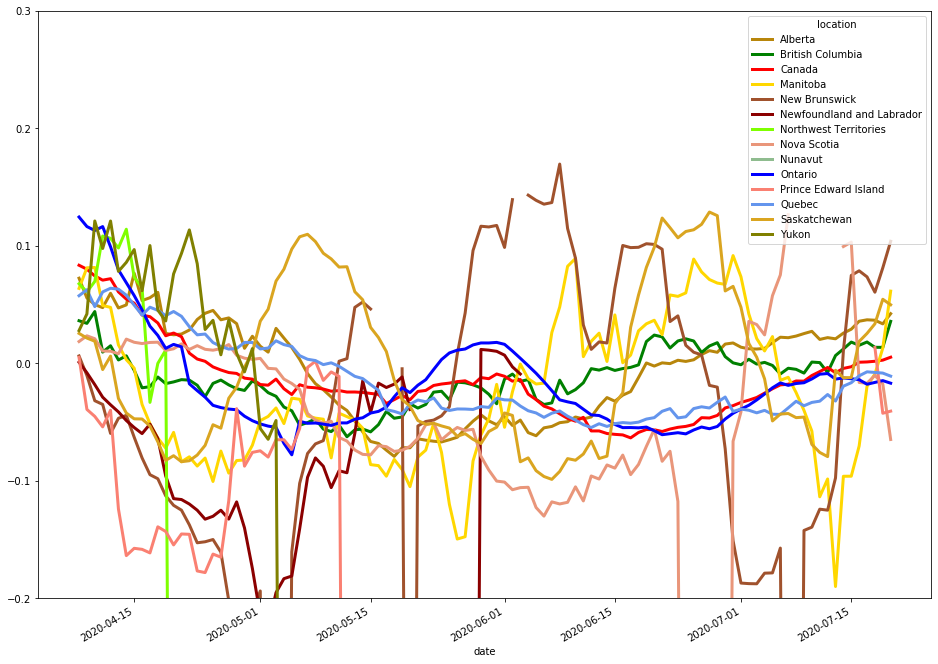

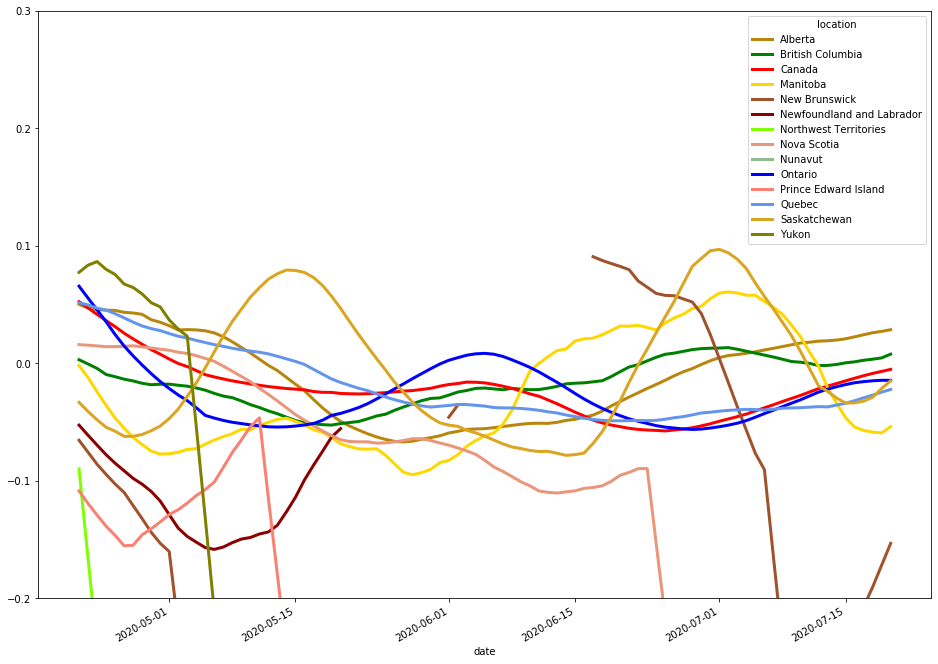

In [35]:
locations = can.provinces
pt_rate_growth = can.growth_rate("pos_test_rate", 14, *locations)

pt_rate_growth_ma = pt_rate_growth.rolling(14).mean()

pt_rate_growth.plot(
    figsize=(16,12),
    color=[can.prov_colours[loc] for loc in sorted(locations)],
    lw = 3,
    ylim=[-0.2,0.3]
)

pt_rate_growth_ma.plot(
    figsize=(16,12),
    color=[can.prov_colours[loc] for loc in sorted(locations)],
    lw = 3,
    ylim=[-0.2,0.3]
)

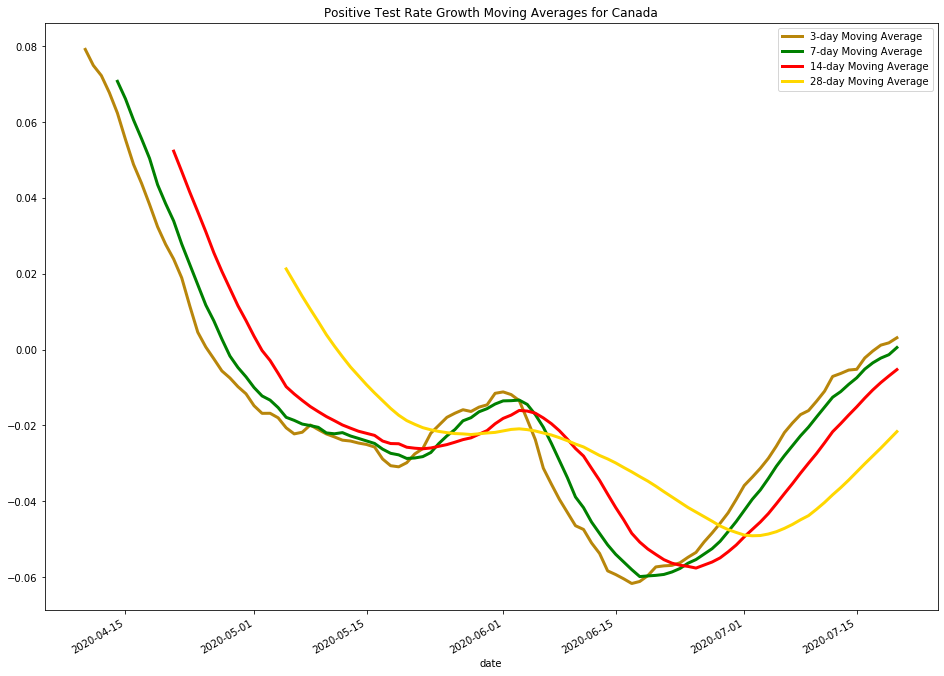

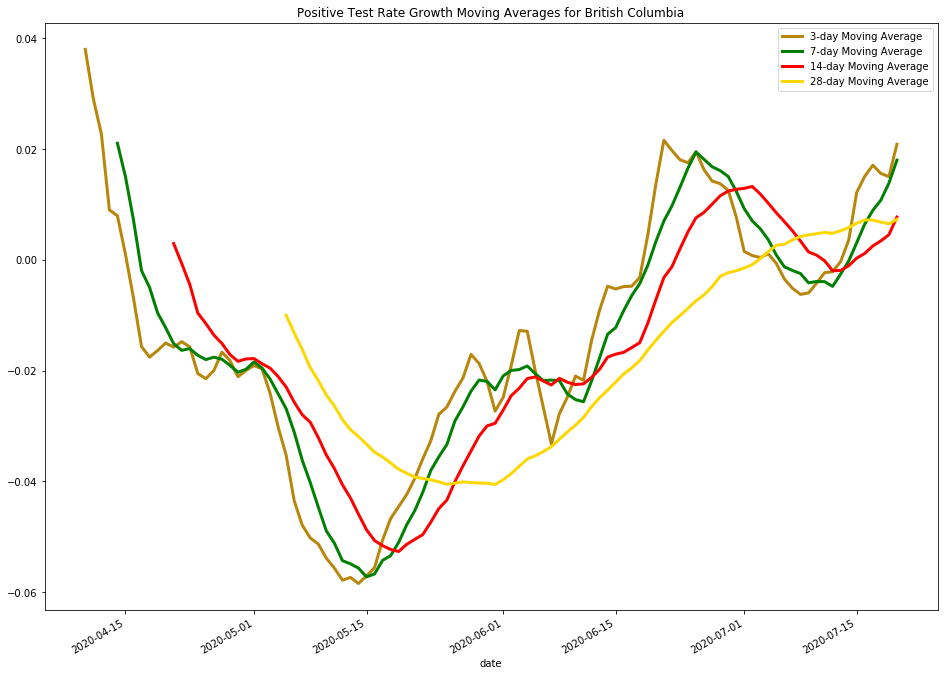

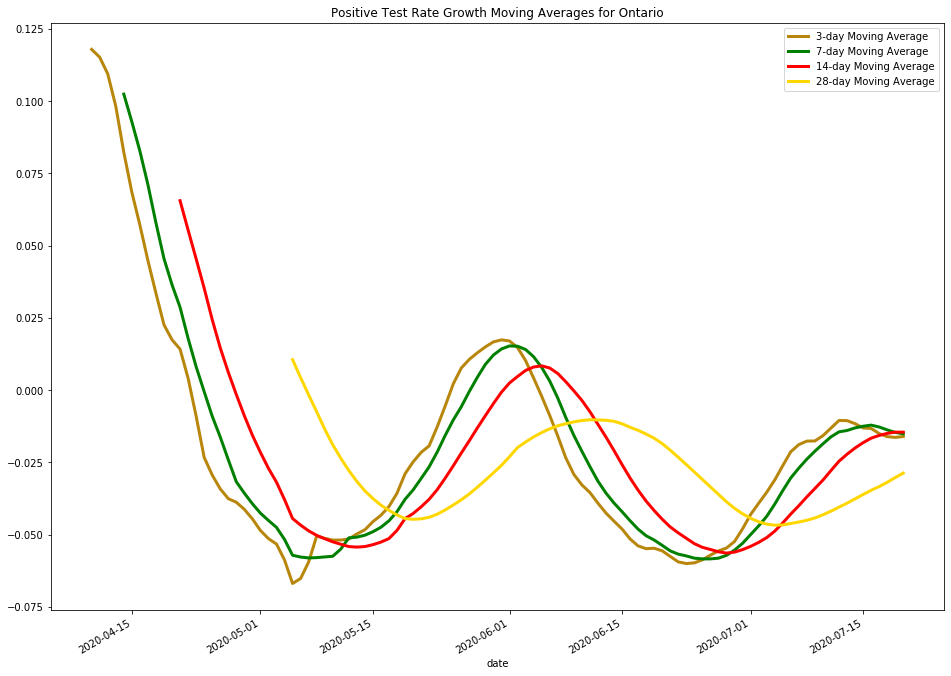

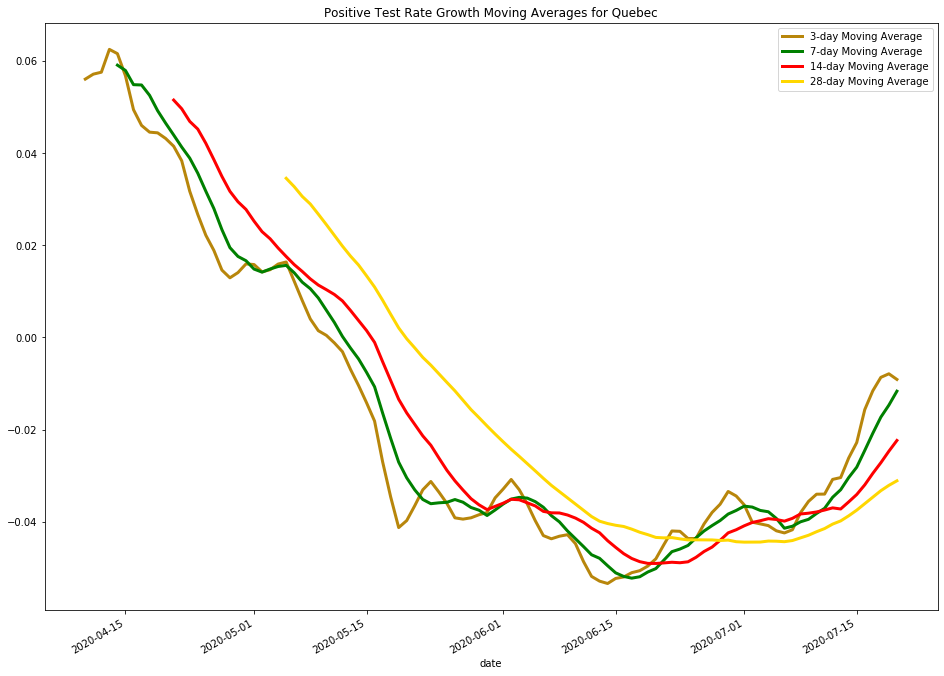

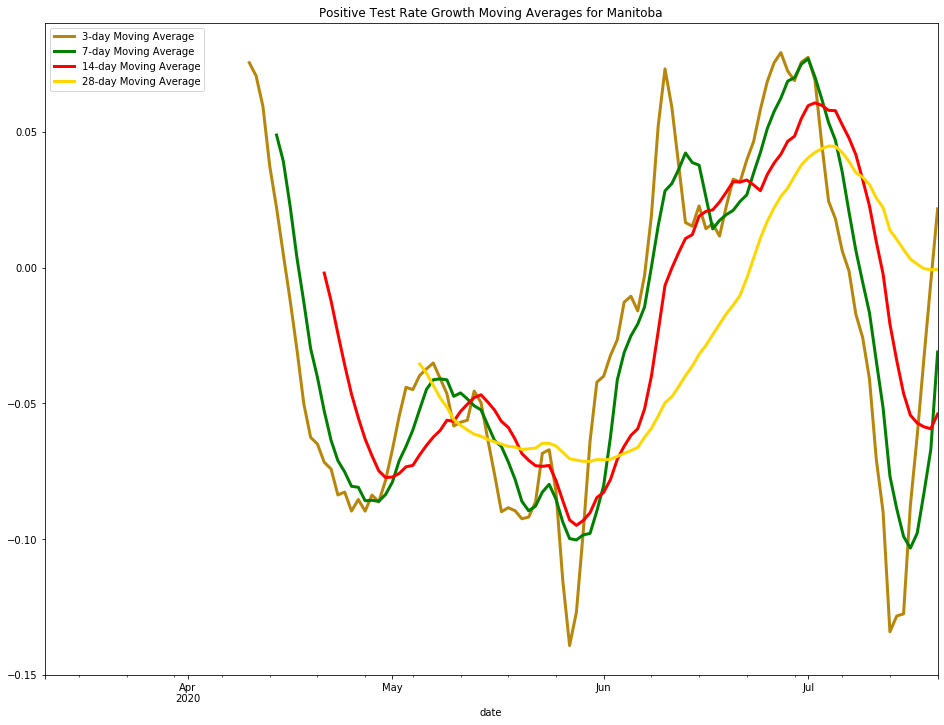

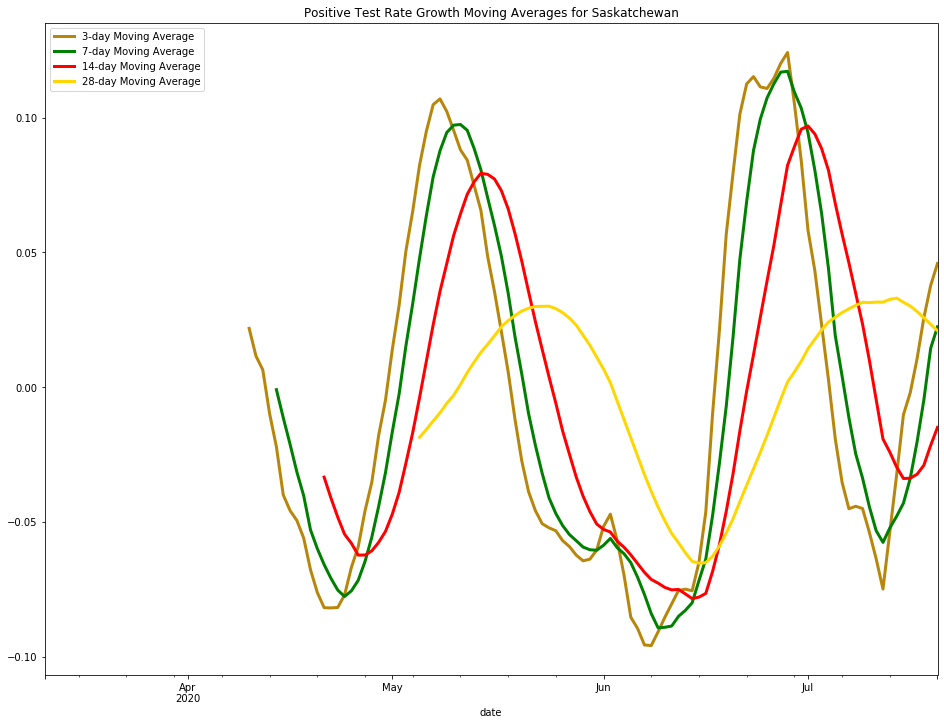

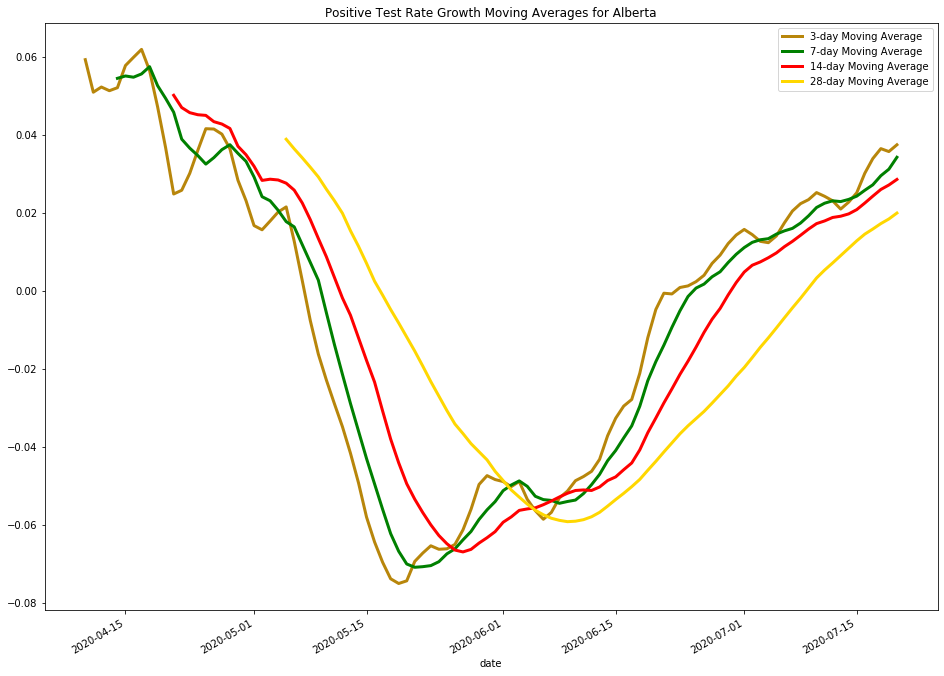

In [61]:
for location in (can.large_provinces + can.prairies):

    pt_rate_growth = can.growth_rate("pos_test_rate", 14, location)

    pt_rate_growth_ma = pd.DataFrame.from_dict(
        {f"{window}-day Moving Average": pt_rate_growth.rolling(window).mean()[location] 
         for window in [3,7, 14, 28]}
    )



    pt_rate_growth_ma.plot(
        figsize=(16,12),
        color=[can.prov_colours[loc] for loc in sorted(locations)],
        lw = 3, 
        title=f"Positive Test Rate Growth Moving Averages for {location}"
    )
    
    savefile = f"{as_of}_PTGRMAs_{location}.png"
    plt.savefig(Path.home().joinpath("Downloads/" + savefile),
               format="png")


TypeError: '<' not supported between instances of 'numpy.float64' and 'Timestamp'

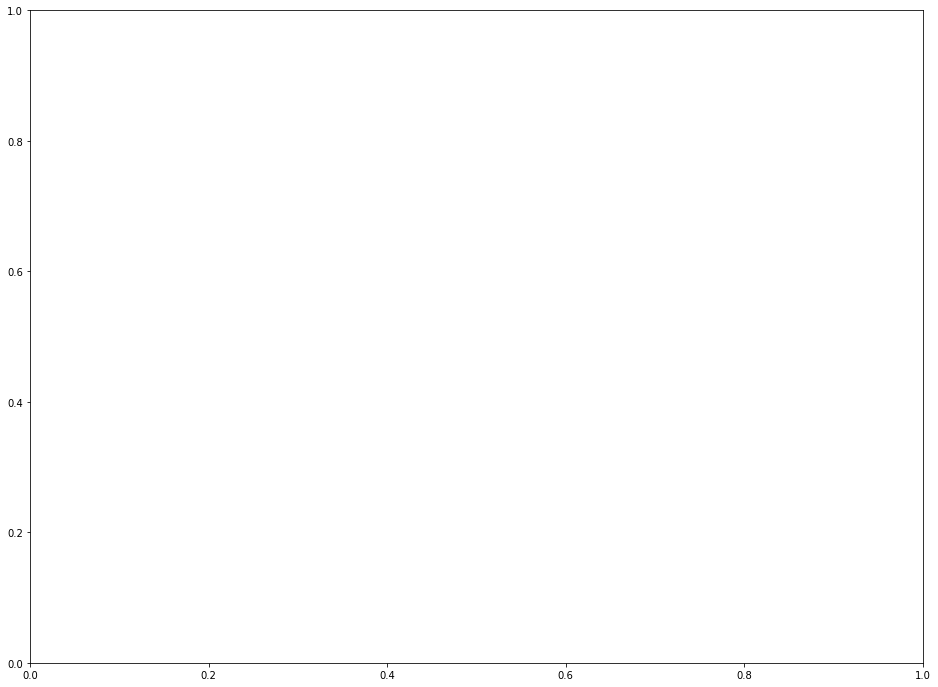

In [21]:
fig = can.plot_location('Ontario', from_date="2020-03-15")

plt.show()

# World

In [ ]:
from src.ecdc import ECDC

world = ECDC()
fig = world.plot_location('World', from_date="2020-01-01")

plt.show()

In [ ]:
ma_win = 7
us_nc_fig = world.plot_var("new_cases_per_million", 'United States', 'Canada', ma_window=ma_win,
    figsize=(16,16),
    #log_scale=True,
    date_start="2020-03-01",
    date_end=as_of,
    colours={'United States': 'blue', 'Canada': 'red'},
    lw=6,
    title=f"{ma_win} day moving average of new cases per million as of {as_of}"  
)

savefile = f"{as_of}_US_CAN_NC_{ma_win}-Day_MA.png"
plt.savefig(Path.home().joinpath("Downloads/" + savefile),
           format="png")

plt.show()

In [ ]:
us_active_growth = world.active_growth_rate(7,"United States")
us_active_growth.plot()

In [ ]:
# Plot the positive test rate over the last ma_win days
ma_win = 14
locations = ['Canada', 'United States']

world_nt_rtot = world.var_by_location("total_tests", *locations).diff(periods=ma_win)
world_nc_rtot = world.var_by_location("total_cases", *locations).diff(periods=ma_win)
world_pt_rolling = world_nc_rtot / (1 * world_nt_rtot)

world_pt_rolling[-90:].plot(figsize=(16,12),color=["red", "blue"])

savefile = f"{as_of}_US_CAN_PT_rate.png"
plt.savefig(Path.home().joinpath("Downloads/" + savefile),
           format="png")

In [ ]:
world_nc_rtot[-21:]

In [ ]:
def prob_exposure(group_size, ptr):
    return 1 - np.power(1 - ptr, group_size)

group_size = 20
world_pe = world_pt_rolling.apply(lambda ptr: prob_exposure(group_size, ptr))

print(world_pe[-1:].values)
print(list(world_pe.columns))


pe_fig, pe_ax = plt.subplots(figsize=(16,12))

pe_ax.barh(list(world_pe.columns), 100 * world_pe[-1:].values[0])
pe_ax.set_xlabel("Percent")
pe_ax.set_title(f"Probability someone in a group of {group_size} has COVID-19")

savefile = f"{as_of}_COVID-19_WorldProbExp_{group_size}.png"
plt.savefig(Path.home().joinpath("Downloads/" + savefile),
           format="png")

plt.show()

In [ ]:
countries = ['Canada', 
             'China', 
             'United States', 
             'Italy', 
             'Spain', 
             'United Kingdom', 
             'Germany',
             'Russia']

world.cum_pos_test_rate(*countries)[-7:]

In [ ]:
world.plot_var("cum_pos_test_rate", *countries)

plt.show()

In [ ]:
world.get_location('China')[['total_tests', 'tests_units', 'total_tests_per_thousand']]

In [ ]:
world.df.columns

In [ ]:
fig = plt.figure(figsize=(16,12))

fig.add_axes()
fig.get_axes()

#ax1 = world.plot_var("total_cases_growth", 'Canada')
#ax2 = world.plot_var("total_cases", 'Canada')